In [1]:
import os
import pandas as pd
import numpy as np

import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import pearsonr,spearmanr
import warnings
warnings.filterwarnings("ignore")#忽略警告

import datetime
from collections import Counter
from scipy import stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler

from calendar import day_abbr, month_abbr, mdays
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2, mean_absolute_percentage_error as MAPE

In [2]:
df=pd.read_csv('./data/preprocessed/data.csv')
df['Date']=pd.to_datetime(df['Date'].astype('str'))
df.rename(columns={'Date':'ds','Price':'y'},inplace=True)

In [3]:
def plot_predictions(forecast, start_date):
    """
    Function to plot the predictions 
    """
    f, ax = plt.subplots(figsize=(12, 6))
    
    train = forecast.loc[start_date:'2022-02-28',:]
    ax.plot(train.index, train.y, 'ko',label='Train True', markersize=3)
    ax.plot(train.index, train.yhat1, label='Train Predict',color='steelblue', lw=0.5)

    test = forecast.loc['2022-03-01':,:]
    ax.plot(test.index, test.y,'ro',label='Test True', markersize=3)
    ax.plot(test.index, test.yhat1, label='Test Predict',color='coral', lw=0.5)
    ax.axvline(forecast.loc['2022-03-01', 'ds'], color='k', ls='--', alpha=0.7)

    ax.grid(ls=':', lw=0.5)
    sns.set_context('paper', font_scale=3, rc={'lines.linewidth':1.2}) 
    plt.legend(loc='best')
    plt.tight_layout()
    return f, ax

In [4]:
def create_joint_plot(forecast, x='yhat1', y='y', title=None): 

    g = sns.jointplot(x='yhat1', y='y', data=forecast, kind="reg", color="b")
    g.fig.set_figwidth(8)
    g.fig.set_figheight(8)
    
    ax = g.fig.axes[1]
    if title is not None: 
        ax.set_title(title, fontsize=16)

    ax = g.fig.axes[0]
    ax.text(10, 130, "R = {:+4.2f}".format(forecast.loc[:,['y','yhat1']].corr().iloc[0,1]), fontsize=16)
    ax.set_xlabel('Predictions', fontsize=15)
    ax.set_ylabel('Observations', fontsize=15)
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 150)
    ax.grid(ls=':')
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

    ax.grid(ls=':')

### Autoregression

In [5]:
df1=df.loc[:,['ds','y']]

In [6]:
m = NeuralProphet(n_lags=1,
                  seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True,
                  daily_seasonality=False,
                  learning_rate=0.1,
                  ar_reg=0.1,)
# m.add_country_holidays(country_name='SE')

train, test= m.split_df(df1, freq='1D', valid_p = 61)
metrics = m.fit(train, freq='1D',validation_df=test)

forecast = m.predict(df1)
forecast.set_index('ds',drop=False,inplace=True)
result=forecast[['y','yhat1']].dropna().apply(lambda x:x.astype(float))

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.918% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.913% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 185
Epoch[185/185]: 100%|█| 185/185 [00:40<00:00,  4.55it/s, SmoothL1Loss=0.0113, MAE=4.73, RMSE=8.25, RegLoss=2.03e-5, MAE
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.918% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.9

In [7]:
y_pred=result.loc['2022-03-01':,'yhat1']
y_test=result.loc['2022-03-01':,'y']
print('MSE: %f, r2 score: %f and MAPE: %f \n' %(MSE(y_test,y_pred), R2(y_test,y_pred),MAPE(y_test,y_pred)))

MSE: 388.417526, r2 score: 0.391850 and MAPE: 0.363806 



residual Mean: 4.142948,Median: 1.847852, skewness 0.099465, kurtosis: 2.823424


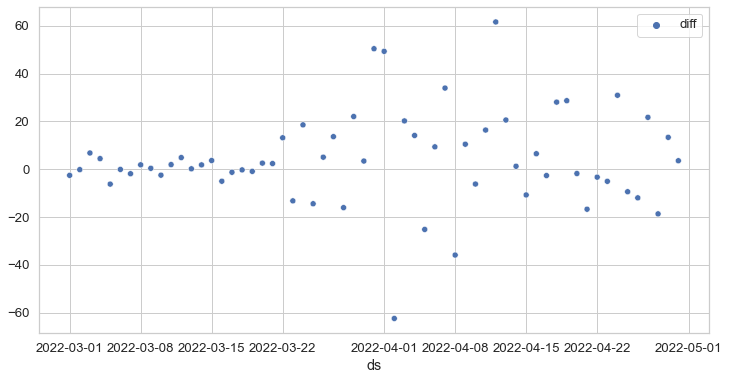

In [8]:
y_pred=pd.DataFrame(y_pred,columns=['yhat1'])
y_test=pd.DataFrame(y_test,columns=['y'])
residual=y_test.y-y_pred.yhat1
residual=pd.DataFrame(residual,columns=['diff'])
plt.figure(figsize=(12, 6))
# sns.set_theme(style="whitegrid")
sns.set_context('notebook', font_scale=1.2, rc={'lines.linewidth':1}) 
sns.scatterplot(data=residual)
print('residual Mean: %f,Median: %f, skewness %f, kurtosis: %f' 
      %(residual.mean(),residual.median(),residual.skew(),residual.kurt()))

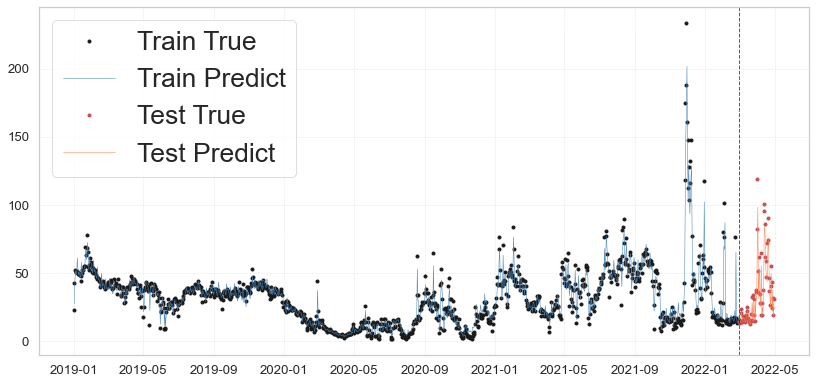

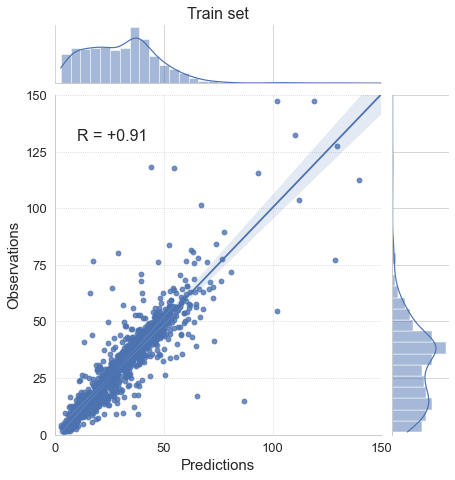

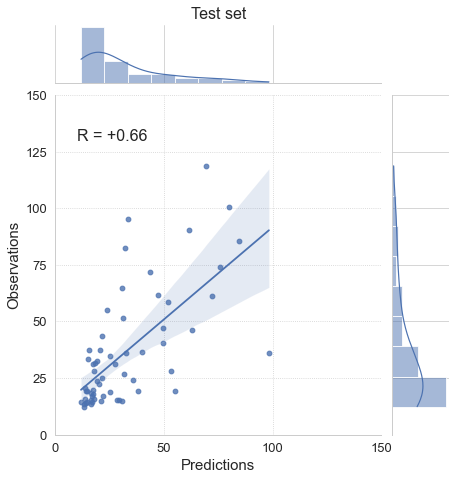

In [9]:
f, ax = plot_predictions(forecast, '2019-01-01')
create_joint_plot(result.loc[:'2022-02-28', :], title='Train set')
create_joint_plot(result.loc['2022-03-01':, :], title='Test set')

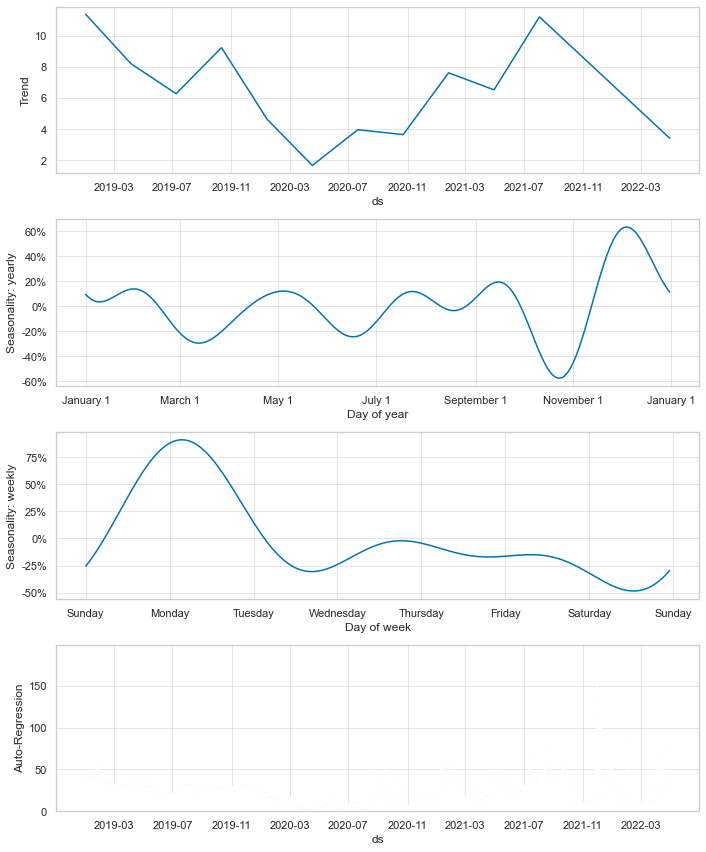

In [10]:
sns.set_context('notebook', font_scale=1, rc={'lines.linewidth':1.5}) 
fig_comp = m.plot_components(forecast)

In [11]:
# m = m.highlight_nth_step_ahead_of_each_forecast(1)
# fig_param = m.plot_parameters()

In [12]:
# df2=pd.DataFrame(df[['ds','y','gas','temp']])
df2=pd.DataFrame(df[['ds','y','wind','gas','crude','precip']])
# df2=df.copy()
m_add_au = NeuralProphet(n_lags=1,
                        seasonality_mode='multiplicative',
                        yearly_seasonality=True,
                        weekly_seasonality=True,
                        daily_seasonality=False,
                        learning_rate=0.1,
                        ar_reg=0.1,)
# m_add_au = m_add_au.add_lagged_regressor(names=['gas','temp'])
# m_add_au = m_add_au.add_lagged_regressor(names='GDP')
m_add_au = m_add_au.add_lagged_regressor(names='gas')
m_add_au = m_add_au.add_lagged_regressor(names='crude')
# m_add_au = m_add_au.add_lagged_regressor(names='EG')
m_add_au = m_add_au.add_lagged_regressor(names='wind')
# m_add_au = m_add_au.add_lagged_regressor(names='carbon')
# m_add_au = m_add_au.add_lagged_regressor(names='temp')
# m_add_au = m_add_au.add_lagged_regressor(names='netimport')
m_add_au = m_add_au.add_lagged_regressor(names='precip')
# m_add_au = m_add_au.add_lagged_regressor(names='EV')


df_train, df_test = m_add_au.split_df(df2, freq='1D', valid_p = 61)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.918% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1D


In [13]:
metrics_au=m_add_au.fit(df_train, freq='1D',validation_df=df_test)
forecast0 = m_add_au.predict(df2)

forecast0.set_index('ds',drop=False,inplace=True)
result0=forecast0[['y','yhat1']].dropna().apply(lambda x:x.astype(float))

y_pred=result0.loc['2022-03-01':,'yhat1']
y_test=result0.loc['2022-03-01':,'y']
print('MSE: %f, r2 score: %f and MAPE: %f \n' %(MSE(y_test,y_pred), R2(y_test,y_pred),MAPE(y_test,y_pred)))

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.913% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 185
Epoch[185/185]: 100%|█| 185/185 [00:51<00:00,  3.57it/s, SmoothL1Loss=0.0111, MAE=4.81, RMSE=8.34, RegLoss=2e-5, MAE_va
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.918% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.918% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1D


MSE: 355.384828, r2 score: 0.443569 and MAPE: 0.390077 



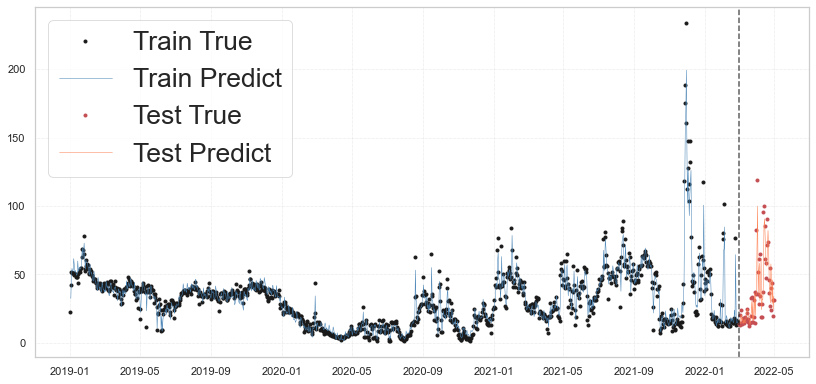

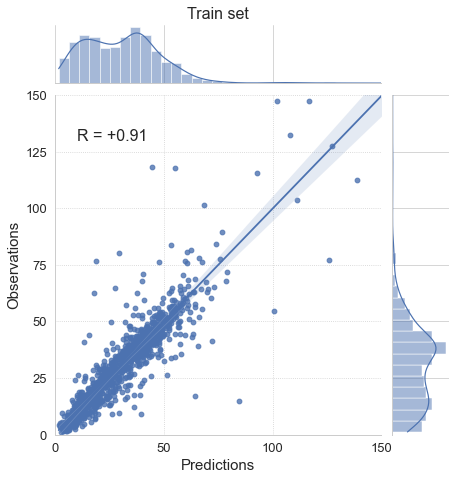

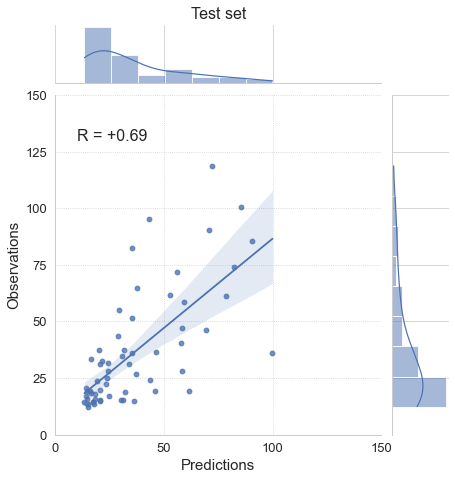

In [14]:
f0, ax0 = plot_predictions(forecast0, '2019-01-01')
create_joint_plot(result0.loc[:'2022-02-28', :], title='Train set')
create_joint_plot(result0.loc['2022-03-01':, :], title='Test set')

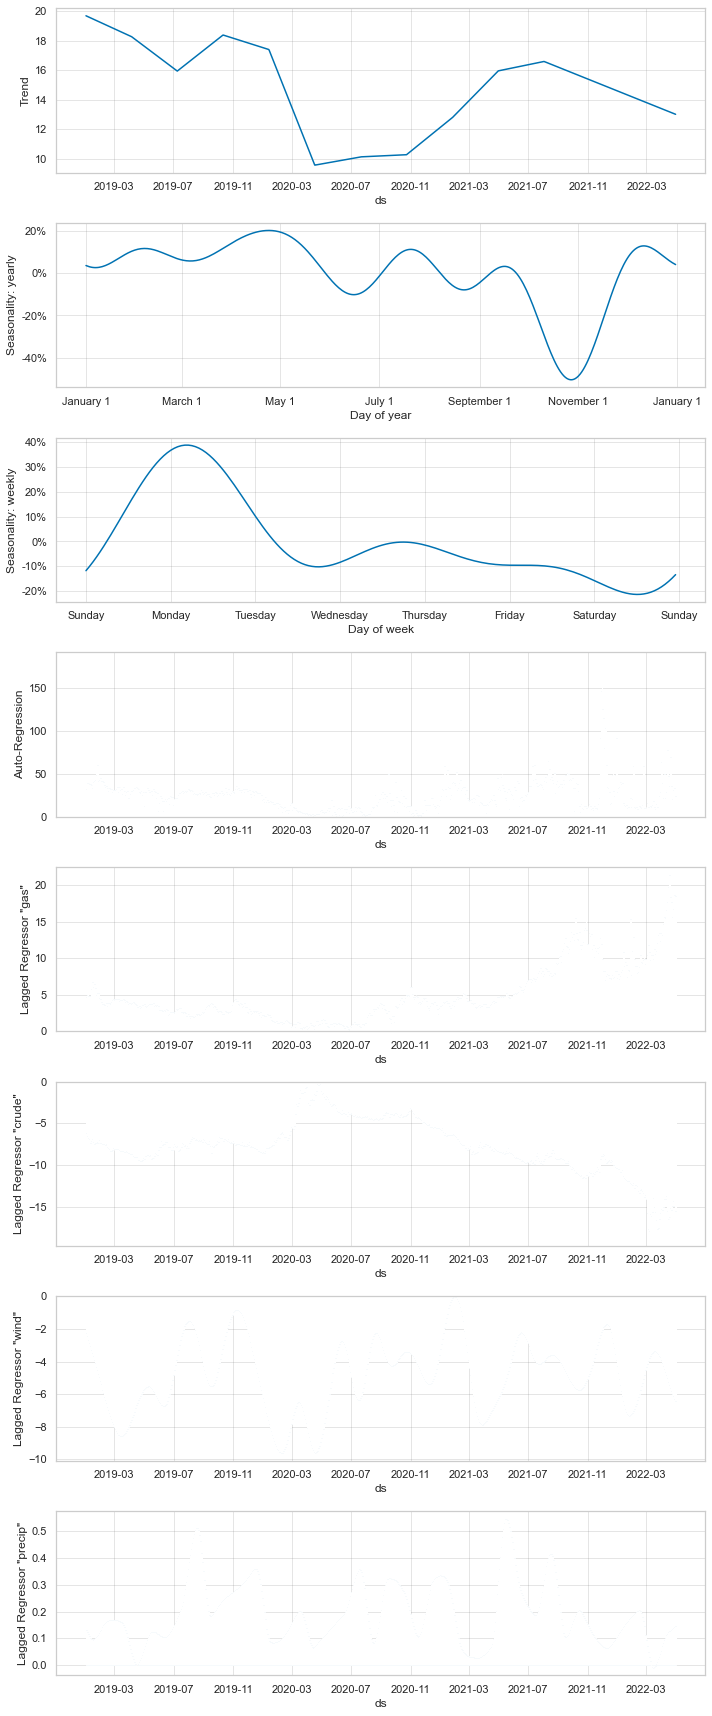

In [15]:
sns.set_context('notebook', font_scale=1, rc={'lines.linewidth':1.5}) 
comp = m_add_au.plot_components(forecast0)

residual Mean: -0.045568,Median: -0.408772, skewness -0.049346, kurtosis: 2.622310


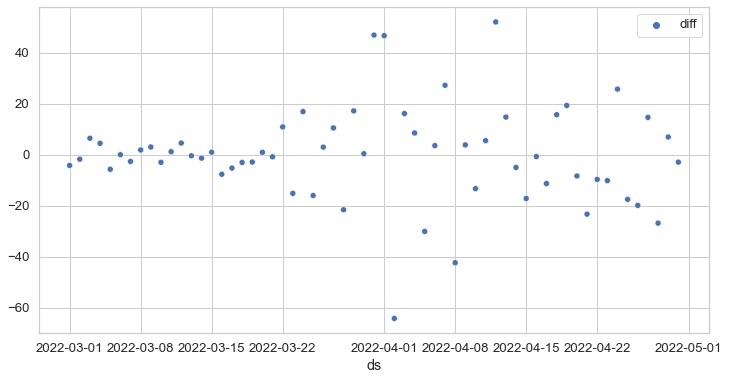

In [16]:
y_pred=pd.DataFrame(y_pred,columns=['yhat1'])
y_test=pd.DataFrame(y_test,columns=['y'])
residual=y_test.y-y_pred.yhat1
residual=pd.DataFrame(residual,columns=['diff'])
plt.figure(figsize=(12, 6))
# sns.set_theme(style="whitegrid")
sns.set_context('notebook', font_scale=1.2, rc={'lines.linewidth':1}) 
sns.scatterplot(data=residual)
print('residual Mean: %f,Median: %f, skewness %f, kurtosis: %f' 
      %(residual.mean(),residual.median(),residual.skew(),residual.kurt()))

MSE: 372.214185, r2 score: 0.417219 and MAPE: 0.368581 AR 
negative GDP,temp,EG,carbon,netimport,EV


MSE: 367.353969, r2 score: 0.424829 and MAPE: 0.398139 wind

MSE: 364.852949, r2 score: 0.428745 and MAPE: 0.443880 wind gas 

MSE: 356.248329, r2 score: 0.442217 and MAPE: 0.390804 wind gas crude 

MSE: 354.378874, r2 score: 0.445144 and MAPE: 0.391883  wind gas crude precip